## Apple IPhone SE Reviews

Dataset Source: https://www.kaggle.com/datasets/kmldas/apple-iphone-se-reviews-ratings

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import transformers
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, set_seed
from transformers import DataCollatorWithPadding

import datasets
from datasets import Dataset, DatasetDict

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Library  ".rjust(15), "Version")
print("*" * 23)

print("Python :".rjust(15), sys.version[0:6])
print("NumPy :".rjust(15), np.__version__)
print("Pandas :".rjust(15), pd.__version__)
print("Torch :".rjust(15), torch.__version__)
print("Datasets :".rjust(15), datasets.__version__)
print("Transformers :".rjust(15), transformers.__version__)
print("Evaluate :".rjust(15), evaluate.__version__)

      Library   Version
***********************
       Python : 3.9.12
        NumPy : 1.24.3
       Pandas : 2.0.1
        Torch : 2.0.0
     Datasets : 2.11.0
 Transformers : 4.28.1
     Evaluate : 0.4.0


#### Ingest Data, Drop Unnecessary Columns, & Rename Remaining Columns

In [3]:
data = pd.read_csv('APPLE_iPhone_SE.csv', 
                   names=['label', 'comment', 'reviews'],
                   dtype={'label': np.float32, 
                           'comment': str, 
                           'reviews': str},
                   engine="c",
                   header=0)

data['text'] = data['comment'] + " : " + data['reviews']

data.drop(columns=['comment', 'reviews'], inplace=True)

data['text'] = data['text'].apply(lambda x: x.split("(\\N{")[0]) + \
               data['text'].apply(lambda x: x.split("})")[-1])

data['label'] = data['label'].astype(np.int8).astype('str') + " Stars"

data

,label,text
0,5 Stars,Super! : Great camera for pics and videos Batt...
1,5 Stars,Must buy! : Great device. Let me tell the Pros...
2,5 Stars,"Great product : Who all loves older size i.e.,..."
3,5 Stars,Simply awesome : This iPhone SE is the best ph...
4,5 Stars,Classy product : This is my second iphone afte...
...,...,...
9708,5 Stars,Terrific purchase : Absolutely brilliantREAD M...
9709,5 Stars,Classy product : Superb phone. This is my 4th ...
9710,5 Stars,Awesome : very niceREAD MOREAwesome : very nic...
9711,5 Stars,Super! : Loving it as of now. Good Product .RE...


#### More Information About Dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9713 entries, 0 to 9712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9713 non-null   object
 1   text    9713 non-null   object
dtypes: object(2)
memory usage: 151.9+ KB


#### Define Function to Create Bar Plot

In [5]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   rotation: np.int8 = 0,
                   annotation: np.bool_ = True
                   ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.
    - rotation: The integer value of the rotation of 
        x-tick values
    - 
    
    Output:
    - A Bar Plot.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(rotation) != np.int8, \
        "The rotation value must be an integer value."
    
    ax = feature_to_visualize.value_counts().plot.bar( 
                                                      figsize=(12,8),
                                                      rot=rotation, 
                                                      legend=False,
                                                      color=["lightgreen", 
                                                             "blue", 
                                                             "brown", 
                                                             "lightblue",
                                                             "tan", 
                                                             "yellow", 
                                                             "orange",
                                                             "green", 
                                                             "red",
                                                             "purple"]
                                                      )
    
    if annotation:
        ax.bar_label(ax.containers[0])
    
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    plt.show()

#### Visualization: Distribution of Scores

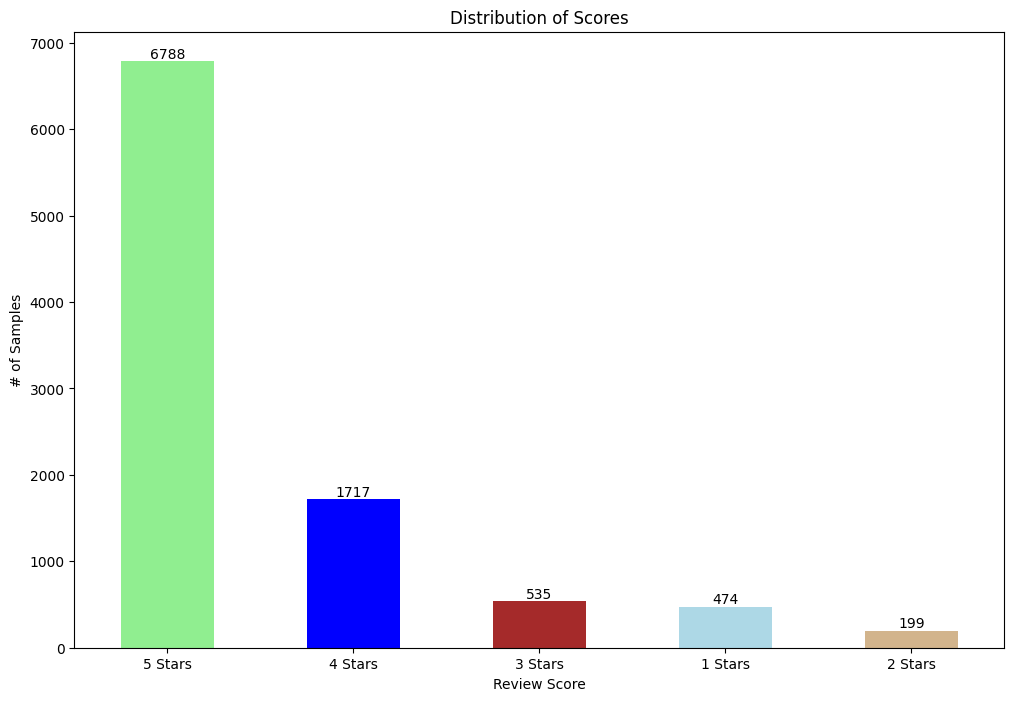

In [6]:
label_distribution = data['label']

barplot_visual(label_distribution,
               "Distribution of Scores",
               "Review Score",
               "# of Samples")

#### Visualization: Distribution of Review Length

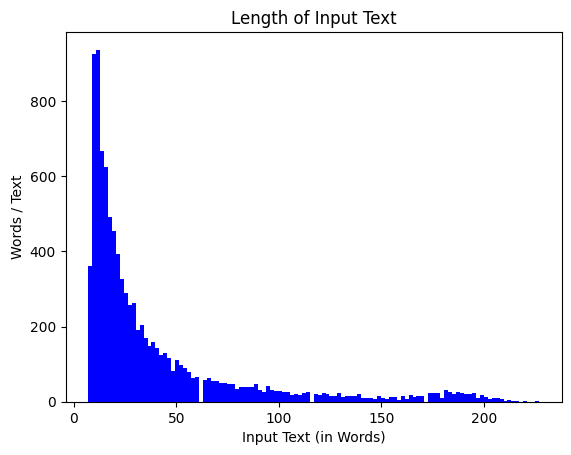

The longest input text is approximately 227 words long.


In [7]:
data['text_length'] = data['text'].str.split().apply(len)

data.hist("text_length", color="Blue", grid=False, bins=114)
plt.title("Length of Input Text")
plt.suptitle('')
plt.xlabel('Input Text (in Words)')
plt.ylabel('Words / Text')
plt.show()

max_len = max(data['text_length'])

print(f"The longest input text is approximately {max_len} words long.")

#### Remove Unnecessary Feature(s)

In [8]:
data = data.drop(columns=['text_length'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9713 entries, 0 to 9712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9713 non-null   object
 1   text    9713 non-null   object
dtypes: object(2)
memory usage: 151.9+ KB


#### Basic Values

In [9]:
NUM_OF_EPOCHS = 5
MAX_INPUT_LENGTH = int(220 * 1.25)

DEVICE = "cpu"
BATCH_SIZE = 64

STRATEGY = "epoch"
MODEL_CKPT = "microsoft/mpnet-base"

MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-apple_iphone_se_reviews"
REPORTS_TO = "tensorboard"

LR = 2e-5
set_seed(42)

NUM_LABELS = 5
label2id = {
    "1 Stars": 0,
    "2 Stars": 1,
    "3 Stars": 2,
    "4 Stars": 3,
    "5 Stars": 4
    }

id2label = {label:idx for idx, label in label2id.items()}

print(label2id)
print(id2label)

{'1 Stars': 0, '2 Stars': 1, '3 Stars': 2, '4 Stars': 3, '5 Stars': 4}
{0: '1 Stars', 1: '2 Stars', 2: '3 Stars', 3: '4 Stars', 4: '5 Stars'}


#### Convert Labels From String to Integer Values

In [10]:
data['label'] = data['label'].replace(label2id)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9713 entries, 0 to 9712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9713 non-null   int64 
 1   text    9713 non-null   object
dtypes: int64(1), object(1)
memory usage: 151.9+ KB


#### Convert DataFrame to Datasets & Split into Training/Evaluation Datasets

In [11]:
dataset = Dataset.from_pandas(data)

train_eval = dataset.train_test_split(test_size=0.20)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test']
})

print('Training data shape:', ds['train'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (7770, 2)
Eval data shape: (1943, 2)


#### Tokenize Whole Dataset

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(batch['text'], 
                     truncation=True, 
                     padding=True, 
                     max_length=MAX_INPUT_LENGTH, 
                     return_tensors="pt")

encoded_ds = ds.map(tokenize, 
                    batched=True, 
                    batch_size=None)

print(encoded_ds['train'].features)
print(encoded_ds['train'])

Map:   0%|          | 0/7770 [00:00<?, ? examples/s]

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

{'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 7770
})


#### Initialize Model

In [13]:
model = (
    AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT, 
        num_labels=NUM_LABELS,
        id2label=id2label,
        label2id=label2id)
    ).to(DEVICE)

Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classif

#### Data Collator

In [14]:
data_collator = DataCollatorWithPadding(tokenizer, 
                                        padding=True)

#### Metrics Evaluation Function

In [15]:
def compute_metrics(p):
    """
    This function takes the predictions output from 
    trainer.evaluate & returns metrics (accuracy, F1, 
    recall, & precision) for a multiclass 
    classification project.
    """
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, 
                                                             axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                      axis=1), 
                                                references=p.label_ids, 
                                                average='weighted')["f1"]
    
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='micro')['f1']
    
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                                  axis=1), 
                                            references=p.label_ids, 
                                            average='weighted')["recall"]
    
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='micro')["recall"]
    
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                        axis=1), 
                                                  references=p.label_ids, 
                                                  average='weighted')["precision"]
    
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='micro')["precision"]
    
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Trainer Arguments

In [16]:
training_args = TrainingArguments(output_dir=MODEL_NAME, 
                                  num_train_epochs=NUM_OF_EPOCHS, 
                                  per_device_train_batch_size=BATCH_SIZE, 
                                  per_device_eval_batch_size=BATCH_SIZE, 
                                  weight_decay=0.01,
                                  learning_rate=LR,
                                  evaluation_strategy=STRATEGY,
                                  logging_strategy='steps',
                                  logging_steps=25,
                                  logging_first_step=True,
                                  save_strategy=STRATEGY, 
                                  report_to=REPORTS_TO,
                                  group_by_length=True,
                                  hub_private_repo=True,
                                  push_to_hub=True)

#### Subclass Trainer to Handle Class Imbalance

In [17]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Build Trainer

In [18]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'],
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics)

Cloning https://huggingface.co/DunnBC22/mpnet-base-apple_iphone_se_reviews into local empty directory.


#### Train the Trainer

In [19]:
training_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/610 [00:00<?, ?it/s]

You're using a MPNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.602, 'learning_rate': 1.99672131147541e-05, 'epoch': 0.01}
{'loss': 1.1275, 'learning_rate': 1.918032786885246e-05, 'epoch': 0.2}
{'loss': 0.8491, 'learning_rate': 1.836065573770492e-05, 'epoch': 0.41}
{'loss': 0.6927, 'learning_rate': 1.7540983606557377e-05, 'epoch': 0.61}
{'loss': 0.5194, 'learning_rate': 1.6721311475409837e-05, 'epoch': 0.82}


  0%|          | 0/31 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.40684521198272705, 'eval_accuracy': 0.8327328872876995, 'eval_Weighted F1': 0.7993487616471537, 'eval_Micro F1': 0.8327328872876993, 'eval_Macro F1': 0.32887477005548477, 'eval_Weighted Recall': 0.8327328872876995, 'eval_Micro Recall': 0.8327328872876995, 'eval_Macro Recall': 0.3855245821114833, 'eval_Weighted Precision': 0.7948115677222908, 'eval_Micro Precision': 0.8327328872876995, 'eval_Macro Precision': 0.30312399537255397, 'eval_runtime': 611.8394, 'eval_samples_per_second': 3.176, 'eval_steps_per_second': 0.051, 'epoch': 1.0}
{'loss': 0.4588, 'learning_rate': 1.5901639344262295e-05, 'epoch': 1.02}
{'loss': 0.3681, 'learning_rate': 1.5081967213114754e-05, 'epoch': 1.23}
{'loss': 0.3334, 'learning_rate': 1.4262295081967214e-05, 'epoch': 1.43}
{'loss': 0.2953, 'learning_rate': 1.3442622950819673e-05, 'epoch': 1.64}
{'loss': 0.264, 'learning_rate': 1.2622950819672132e-05, 'epoch': 1.84}


  0%|          | 0/31 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2356589287519455, 'eval_accuracy': 0.8836850231600618, 'eval_Weighted F1': 0.8644885072415942, 'eval_Micro F1': 0.8836850231600618, 'eval_Macro F1': 0.45598935385523764, 'eval_Weighted Recall': 0.8836850231600618, 'eval_Micro Recall': 0.8836850231600618, 'eval_Macro Recall': 0.5088583722111778, 'eval_Weighted Precision': 0.8529605097109872, 'eval_Micro Precision': 0.8836850231600618, 'eval_Macro Precision': 0.4341074208614427, 'eval_runtime': 610.0352, 'eval_samples_per_second': 3.185, 'eval_steps_per_second': 0.051, 'epoch': 2.0}
{'loss': 0.2659, 'learning_rate': 1.1803278688524591e-05, 'epoch': 2.05}
{'loss': 0.2027, 'learning_rate': 1.0983606557377052e-05, 'epoch': 2.25}
{'loss': 0.1936, 'learning_rate': 1.0163934426229509e-05, 'epoch': 2.46}
{'loss': 0.1722, 'learning_rate': 9.344262295081968e-06, 'epoch': 2.66}
{'loss': 0.1601, 'learning_rate': 8.524590163934427e-06, 'epoch': 2.87}


  0%|          | 0/31 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16468031704425812, 'eval_accuracy': 0.8975810602161606, 'eval_Weighted F1': 0.8774363233455805, 'eval_Micro F1': 0.8975810602161606, 'eval_Macro F1': 0.48630501934265596, 'eval_Weighted Recall': 0.8975810602161606, 'eval_Micro Recall': 0.8975810602161606, 'eval_Macro Recall': 0.5614892316744751, 'eval_Weighted Precision': 0.8696699634040972, 'eval_Micro Precision': 0.8975810602161606, 'eval_Macro Precision': 0.461020549786962, 'eval_runtime': 610.8239, 'eval_samples_per_second': 3.181, 'eval_steps_per_second': 0.051, 'epoch': 3.0}
{'loss': 0.1671, 'learning_rate': 7.704918032786886e-06, 'epoch': 3.07}
{'loss': 0.1406, 'learning_rate': 6.885245901639345e-06, 'epoch': 3.28}
{'loss': 0.1475, 'learning_rate': 6.065573770491804e-06, 'epoch': 3.48}
{'loss': 0.1234, 'learning_rate': 5.245901639344263e-06, 'epoch': 3.69}
{'loss': 0.1281, 'learning_rate': 4.426229508196722e-06, 'epoch': 3.89}


  0%|          | 0/31 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.13984337449073792, 'eval_accuracy': 0.9423571796191457, 'eval_Weighted F1': 0.9322920914691559, 'eval_Micro F1': 0.9423571796191457, 'eval_Macro F1': 0.7092696023153502, 'eval_Weighted Recall': 0.9423571796191457, 'eval_Micro Recall': 0.9423571796191457, 'eval_Macro Recall': 0.7464438781750541, 'eval_Weighted Precision': 0.924443268867862, 'eval_Micro Precision': 0.9423571796191457, 'eval_Macro Precision': 0.6805589698473045, 'eval_runtime': 612.0896, 'eval_samples_per_second': 3.174, 'eval_steps_per_second': 0.051, 'epoch': 4.0}
{'loss': 0.1277, 'learning_rate': 3.6065573770491806e-06, 'epoch': 4.1}
{'loss': 0.123, 'learning_rate': 2.786885245901639e-06, 'epoch': 4.3}
{'loss': 0.1049, 'learning_rate': 1.9672131147540985e-06, 'epoch': 4.51}
{'loss': 0.1091, 'learning_rate': 1.1475409836065575e-06, 'epoch': 4.71}
{'loss': 0.1175, 'learning_rate': 3.278688524590164e-07, 'epoch': 4.92}


  0%|          | 0/31 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.12987616658210754, 'eval_accuracy': 0.9459598558929491, 'eval_Weighted F1': 0.9359769237564278, 'eval_Micro F1': 0.9459598558929491, 'eval_Macro F1': 0.7242136777661108, 'eval_Weighted Recall': 0.9459598558929491, 'eval_Micro Recall': 0.9459598558929491, 'eval_Macro Recall': 0.7593500405849569, 'eval_Weighted Precision': 0.929023836280776, 'eval_Micro Precision': 0.9459598558929491, 'eval_Macro Precision': 0.7007419659301912, 'eval_runtime': 610.6404, 'eval_samples_per_second': 3.182, 'eval_steps_per_second': 0.051, 'epoch': 5.0}
{'train_runtime': 45565.3514, 'train_samples_per_second': 0.853, 'train_steps_per_second': 0.013, 'train_loss': 0.29725947360523414, 'epoch': 5.0}


#### Save Model & Metrics

In [20]:
trainer.save_model()
trainer.log_metrics("train", training_results.metrics)
trainer.save_metrics("train", training_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file runs/Jun02_21-31-13_Brians-Mac-mini.local/events.out.tfevents.1685759480.Brians-Mac-mini.local.776…

To https://huggingface.co/DunnBC22/mpnet-base-apple_iphone_se_reviews
   e5bc99c..ad5384c  main -> main

To https://huggingface.co/DunnBC22/mpnet-base-apple_iphone_se_reviews
   ad5384c..0fddf1e  main -> main



***** train metrics *****
  epoch                    =         5.0
  train_loss               =      0.2973
  train_runtime            = 12:39:25.35
  train_samples_per_second =       0.853
  train_steps_per_second   =       0.013


#### Push Model to Hub

In [21]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/mpnet-base-apple_iphone_se_reviews
   0fddf1e..5e8403d  main -> main



'https://huggingface.co/DunnBC22/mpnet-base-apple_iphone_se_reviews/commit/5e8403dd1c8d70aabccac964de9f97e7a473f8be'

### Notes & Other Takeaways From This Project

****
- I also completed a version of this project using the Bert-Base checkpoint (as well as Weights & Biases). The results for macro-F1, macro-recall, and macro-precision were all much better (results in the 0.95-0.96 range).
****

### Citation

- Model Checkpoint (Microsoft/mpnet-base)

    > https://huggingface.co/microsoft/mpnet-base (since there is not citation provided, this is the enxt best option).